## MSCA 31008 - Data Mining Principles - Course Project

### Predicting Pet Adoption Speed at Pet Shelters : Exploratory Data Analysis
### Submitted by:

Saurabh Srivastava
Raghav Atal
Rima Mittal
Tobel Ezeokoli

@uchicago.edu

In this dataset we have variety of information: structured data, texts and images. This gives a lot of possibilties for feature engineering and modelling. 

We would explore the data on following facets:
* comparing distribution of features in train and test data
* exploring features and their interactions

### Import required packages and import raw data

In [1]:
#libraries
import numpy as np 
import pandas as pd 
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from PIL import Image
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc
from catboost import CatBoostClassifier
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import random
import warnings
warnings.filterwarnings("ignore")
from functools import partial
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import os
import scipy as sp
from math import sqrt
from collections import Counter
from sklearn.metrics import confusion_matrix as sk_cmatrix

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
import langdetect
import eli5
from IPython.display import display 

from sklearn.metrics import cohen_kappa_score
def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

Load raw data files

In [5]:
breeds = pd.read_csv('breed_labels.csv')
colors = pd.read_csv('color_labels.csv')
states = pd.read_csv('state_labels.csv')

train = pd.read_csv('train.csv')
train_df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])

## Data overview

In [8]:
train.drop('Description', axis=1).head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed,dataset_type
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2,train
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0,train
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3,train
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8.0,2,train
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3.0,2,train


* We have almost 15 thousands dogs and cats listings in the dataset
* Main dataset contains all important information about pets: age, breed, color, some characteristics and other things;
* Desctiptions were analyzed using Google's Natural Language API providing sentiments and entities.
* There are photos of some pets
* Some meta-information was extracted from images using Google's Vision API
* There are separate files with labels for breeds, colors and states

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

### Observation 1

Train.csv has two columns (Name and Description) which have missing values. What can we do to fill in the blanks. 

Q - Can we drop the name column? can a certain name impacts the speed of adoption?

Q - Can we fill in the name column with the most common dog name?

Q - How do we fill the missing descriptions?

## Main data exploration

### Target: Adoption speed

* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days). 

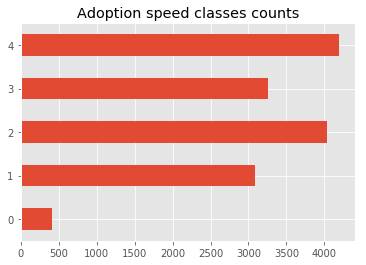

In [10]:
train['AdoptionSpeed'].value_counts().sort_index().plot('barh');
plt.title('Adoption speed classes counts');

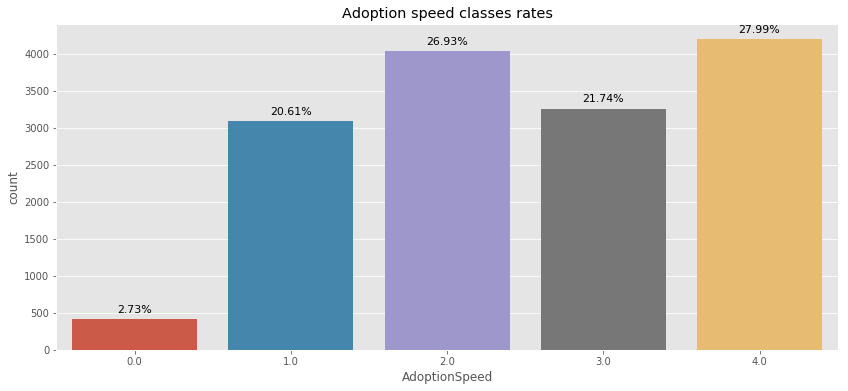

In [11]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=all_data.loc[all_data['dataset_type'] == 'train'])
plt.title('Adoption speed classes rates');
ax=g.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, rotation=0, xytext=(0, 10),
         textcoords='offset points')  

#### Calculating the percentage for each adoption speed in Training data

In [12]:
as_descrp_dict = {0:'Adopted on the same day as it was listed.', 
                1:'Adopted between 1 and 7 days (1st week) after being listed.' ,
                2:'Adopted between 8 and 30 days (1st month) after being listed.',
                3:'Adopted between 31 and 90 days (2nd & 3rd month) after being listed.',
                4:'No adoption after 100 days of listing. (No pets that waited between 90 and 100 days).'
                 }

In [13]:
def getValueCountsForFeature(df,col):
    value_counts = df[col].value_counts()
    return value_counts

def getPercentCountForFeatureValue(df,col):
    value_counts = getValueCountsForFeature(df,col)
    total = np.sum(value_counts)
    result = (value_counts*100)/total
    return result

In [14]:
result = getPercentCountForFeatureValue(train_df,'AdoptionSpeed')
for idx in result.index:
    print('{}% pets got {} '.format(np.round(result[idx],2), as_descrp_dict[idx]))

27.99% pets got No adoption after 100 days of listing. (No pets that waited between 90 and 100 days). 
26.93% pets got Adopted between 8 and 30 days (1st month) after being listed. 
21.74% pets got Adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
20.61% pets got Adopted between 1 and 7 days (1st week) after being listed. 
2.73% pets got Adopted on the same day as it was listed. 


We can see that some pets were adopted immediately, but these are rare cases: maybe someone wanted to adopt any pet, or the pet was lucky to be seen by person, who wanted a similar pet. A lot of pets aren't adopted at all, which is quite sad.

### Type
1 - Dog, 2 - Cat

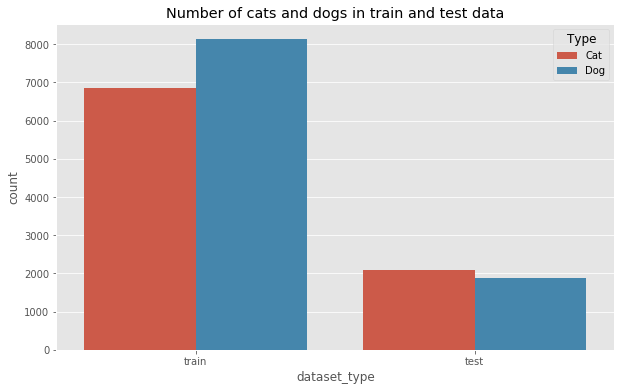

In [15]:
all_data['Type'] = all_data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
plt.figure(figsize=(10, 6));
sns.countplot(x='dataset_type', data=all_data, hue='Type');
plt.title('Number of cats and dogs in train and test data');

#### Comparison of adoption rates

From here on we will compare not only counts of pets in different categories, but also compare adoption speed rates with base ones.

This is how it works:
* As we saw earlier the base rate of pets with Adoption speed 0 is 410 / 14993 = 0.027;
* Now look at the next graph: there are 6861 cats in train dataset and 240 of them have Adoption Speed 0. So the rate is 240 / 6861 = 0.035;
* 0.035/0.027 = 1.28, so by splitting out the data to cat vs dog, we can see that cats have a 28% increased chance of adoption speed class 0 over the base rate of adoption;

In [16]:
main_count = train['AdoptionSpeed'].value_counts(normalize=True).sort_index()
def prepare_plot_dict(df, col, main_count):
    """
    Preparing dictionary with data for plotting.
    
    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def make_count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue);
    plt.title(f'AdoptionSpeed {title}');
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x, main_count)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color='green' if plot_dict[h] > 0 else 'red', rotation=0, xytext=(0, 10),
             textcoords='offset points')  

#### Pie Chart of Adoption Speed in Training data

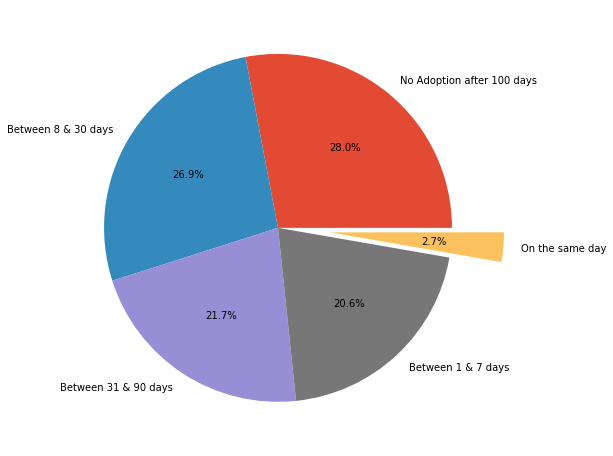

In [17]:
value_counts = getPercentCountForFeatureValue(train_df,'AdoptionSpeed')
labels=['No Adoption after 100 days','Between 8 & 30 days','Between 31 & 90 days','Between 1 & 7 days','On the same day']
plt.figure(figsize=(8,8))
plt.pie(value_counts,explode=[0.0]*4 + [0.3],labels=labels,autopct='%1.1f%%');

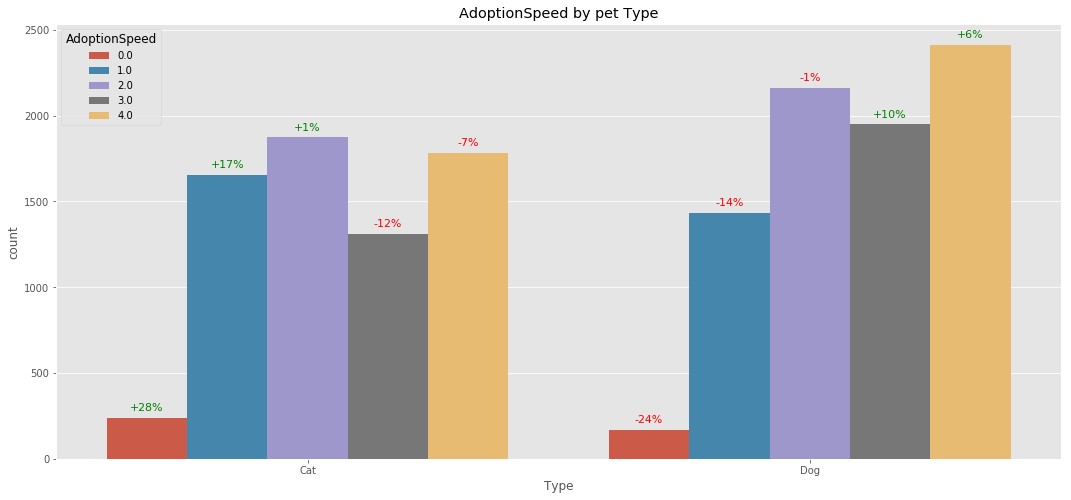

In [18]:
plt.figure(figsize=(18, 8));
make_count_plot(df=all_data.loc[all_data['dataset_type'] == 'train'], x='Type', title='by pet Type')

We can see that cats are more likely to be adopted early than dogs and overall the percentage of not adopted cats is lower. Does this mean people prefer cats? Or maybe this dataset is small and could contain bias.
On the other hand more dogs are adopted after several months.

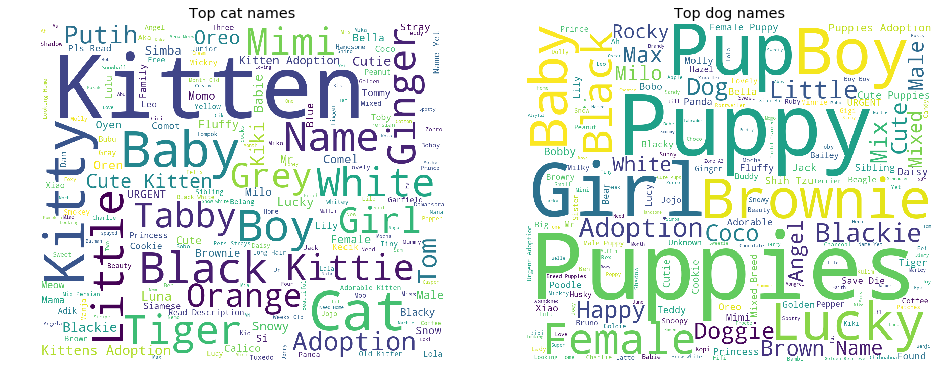

In [19]:
fig, ax = plt.subplots(figsize = (16, 12))
plt.subplot(1, 2, 1)
text_cat = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis("off")

plt.show()

#### Q - There is also a value as "No Name" in the data. Shall we put this in the missing values?

In [20]:
print('Most popular pet names and AdoptionSpeed')
for n in train['Name'].value_counts().index[:5]:
    print(n)
    print(train.loc[train['Name'] == n, 'AdoptionSpeed'].value_counts().sort_index())
    print('')

Most popular pet names and AdoptionSpeed
Baby
0     2
1    11
2    15
3    11
4    27
Name: AdoptionSpeed, dtype: int64

Lucky
0     5
1    14
2    16
3    12
4    17
Name: AdoptionSpeed, dtype: int64

Brownie
0     1
1    11
2    14
3    12
4    16
Name: AdoptionSpeed, dtype: int64

No Name
0     3
1    14
2    11
3     6
4    20
Name: AdoptionSpeed, dtype: int64

Mimi
0     3
1    12
2    13
3     7
4    17
Name: AdoptionSpeed, dtype: int64



#### No name

In [21]:
train['Name'] = train['Name'].fillna('Unnamed')
test['Name'] = test['Name'].fillna('Unnamed')
all_data['Name'] = all_data['Name'].fillna('Unnamed')

train['No_name'] = 0
train.loc[train['Name'] == 'Unnamed', 'No_name'] = 1
test['No_name'] = 0
test.loc[test['Name'] == 'Unnamed', 'No_name'] = 1
all_data['No_name'] = 0
all_data.loc[all_data['Name'] == 'Unnamed', 'No_name'] = 1

print(f"Rate of unnamed pets in train data: {train['No_name'].sum() * 100 / train['No_name'].shape[0]:.4f}%.")
print(f"Rate of unnamed pets in test data: {test['No_name'].sum() * 100 / test['No_name'].shape[0]:.4f}%.")

Rate of unnamed pets in train data: 8.4173%.
Rate of unnamed pets in test data: 7.6748%.


In [22]:
pd.crosstab(train['No_name'], train['AdoptionSpeed'], normalize='index')

AdoptionSpeed,0,1,2,3,4
No_name,,,,,
0,0.027966,0.205302,0.271211,0.221470,0.274051
1,0.020602,0.214739,0.248019,0.172742,0.343899


Less than 10% of pets don't have names, but they have a higher possibility of not being adopted.

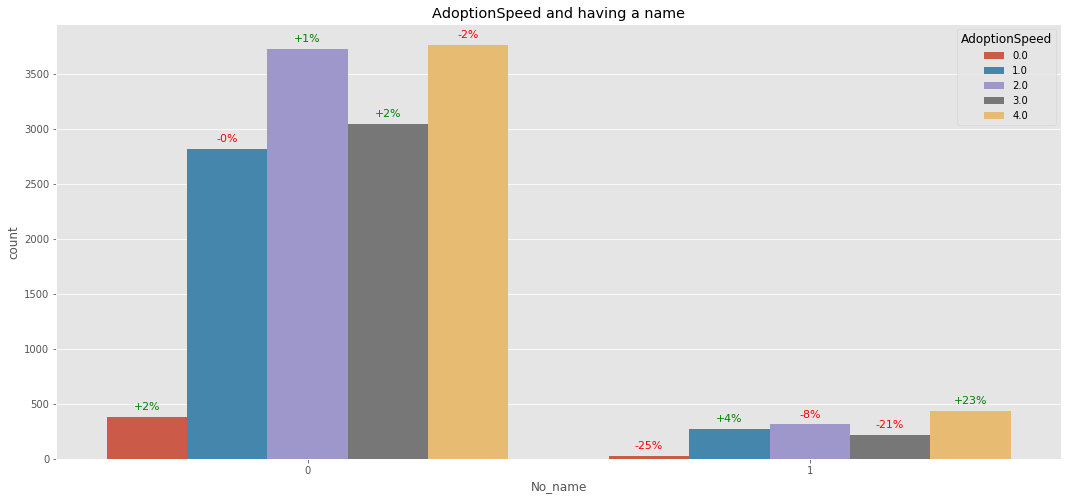

In [23]:
plt.figure(figsize=(18, 8));
make_count_plot(df=all_data.loc[all_data['dataset_type'] == 'train'], x='No_name', title='and having a name')

#### "Bad" names

There are observations noticed that shorter names tend to be meaningless.Examples below:

In [24]:
all_data[all_data['Name'].apply(lambda x: len(str(x))) == 3]['Name'].value_counts().tail()

JEF    1
No4    1
Tam    1
BB3    1
ACI    1
Name: Name, dtype: int64

And here are names with 1 or 2 characters...

In [25]:
all_data[all_data['Name'].apply(lambda x: len(str(x))) < 3]['Name'].unique()

array(['H3', 'Z3', 'C', 'BB', 'QQ', 'Y1', 'H1', 'D9', 'Y4', 'Z4', 'DD',
       'M2', 'H6', 'D4', 'JJ', 'F1', 'W7', '1F', 'Q1', '6', 'CJ', '3F',
       'KD', 'G1', 'B3', 'Cc', 'F6', 'Mk', 'A5', 'GM', 'D5', 'EE', 'A4',
       'Q4', 'B', 'CC', 'Y7', 'W6', 'A3', 'A1', 'T1', 'W1', 'M4', 'P5',
       'H2', 'GG', 'Y6', 'Z', 'D7', 'B4', 'C2', 'M8', '3', 'G2', 'ML',
       'DJ', 'PP', '8', 'OJ', 'D', 'F2', 'MJ', 'W8', 'W4', 'C1', 'W2',
       'GR', 'B1', '5', 'Fa', 'Y5', 'M', 'F5', 'Y0', 'B2', 'Q6', 'G3',
       '..', 'S1', 'Qu', 'R9', 'W3', 'R7', 'Tj', 'P3', '7', '!', 'RC',
       'Z2', 'Q3', 'A2', 'QD', 'S', '-', 'R6', 'IV', 'Mo', 'W5', 'F8',
       'M6', 'M9', 'Py', 'Rt', 'F9', 'P6', 'AJ', 'Y3', 'D6', 'T2', 'F4',
       'T3', 'YY', '99', 'F7', 'W+', 'D2', '1', '#1', 'S4', '2', 'Am',
       'P', 'P4', 'R5', 'M3', 'R3', 'JD', 'BJ', 'L', 'KC', 'VV', 'M1',
       '!.', 'V6', 'P1', 'J', 'S3', 'A6', 'Cq', 'M5', 'B5', 'J1', 'O',
       '2F', 'Q2', 'Y2', 'AB', 'A', 'Jo', 'ET', 'A9', 'ST', 'Po', 'KK'

We could create a new feature, showing that name is meaningless - pets with these names could have less success in adoption.

### Age

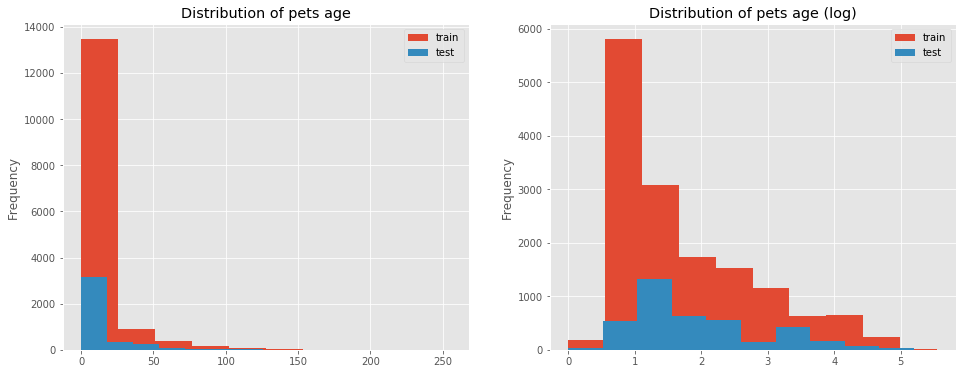

In [26]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.subplot(1, 2, 1)
plt.title('Distribution of pets age');
train['Age'].plot('hist', label='train');
test['Age'].plot('hist', label='test');
plt.legend();

plt.subplot(1, 2, 2)
plt.title('Distribution of pets age (log)');
np.log1p(train['Age']).plot('hist', label='train');
np.log1p(test['Age']).plot('hist', label='test');
plt.legend();

In [27]:
train['Age'].value_counts().head(10)

2     3503
1     2304
3     1966
4     1109
12     967
24     651
5      595
6      558
36     417
8      309
Name: Age, dtype: int64

We can see that most pets are young - maybe after the birth. Also there a lot of pets with an age equal to multiples of 12 - So they are probably guesses

In [28]:
data = []
for a in range(5):
    df = train.loc[train['AdoptionSpeed'] == a]

    data.append(go.Scatter(
        x = df['Age'].value_counts().sort_index().index,
        y = df['Age'].value_counts().sort_index().values,
        name = str(a)
    ))
    
layout = go.Layout(dict(title = "AdoptionSpeed trends by Age",
                  xaxis = dict(title = 'Age (months)'),
                  yaxis = dict(title = 'Counts'),
                  )
                  )
py.iplot(dict(data=data, layout=layout), filename='basic-line')

* We can see that young pets are adopted quite fast and most of them are adopted
* Most pets are less than 4 months old with a huge spike at 2 months
* It seems that a lot of people don't input exact age and write age in years (or multiples of 12)
* It could make sense to create some binary variables based on age

### Breeds
There is a main breed of the pet and secondary if relevant.

At first let's see whether having secondary breed influences adoption speed.

In [29]:
train['Pure_breed'] = 0
train.loc[train['Breed2'] == 0, 'Pure_breed'] = 1
test['Pure_breed'] = 0
test.loc[test['Breed2'] == 0, 'Pure_breed'] = 1
all_data['Pure_breed'] = 0
all_data.loc[all_data['Breed2'] == 0, 'Pure_breed'] = 1

print(f"Rate of pure breed pets in train data: {train['Pure_breed'].sum() * 100 / train['Pure_breed'].shape[0]:.4f}%.")
print(f"Rate of pure breed pets in test data: {test['Pure_breed'].sum() * 100 / test['Pure_breed'].shape[0]:.4f}%.")

Rate of pure breed pets in train data: 71.7802%.
Rate of pure breed pets in test data: 77.9635%.


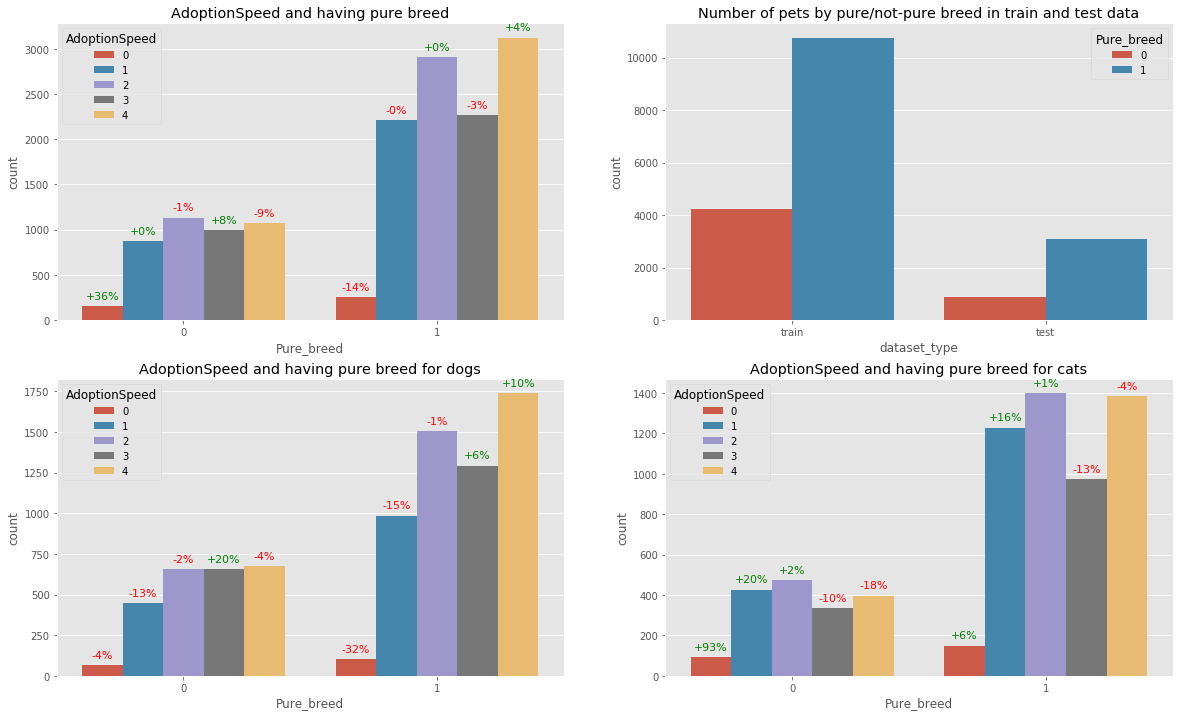

In [30]:
def plot_four_graphs(col='', main_title='', dataset_title=''):
    """
    Plotting four graphs:
    - adoption speed by variable;
    - counts of categories in the variable in train and test;
    - adoption speed by variable for dogs;
    - adoption speed by variable for cats;    
    """
    plt.figure(figsize=(20, 12));
    plt.subplot(2, 2, 1)
    make_count_plot(df=train, x=col, title=f'and {main_title}')

    plt.subplot(2, 2, 2)
    sns.countplot(x='dataset_type', data=all_data, hue=col);
    plt.title(dataset_title);

    plt.subplot(2, 2, 3)
    make_count_plot(df=train.loc[train['Type'] == 1], x=col, title=f'and {main_title} for dogs')

    plt.subplot(2, 2, 4)
    make_count_plot(df=train.loc[train['Type'] == 2], x=col, title=f'and {main_title} for cats')
    
plot_four_graphs(col='Pure_breed', main_title='having pure breed', dataset_title='Number of pets by pure/not-pure breed in train and test data')

It seems that non-pure breed pets tend to be adopted more and faster, especially cats.

Let's look at the breeds themselves

In [31]:
### Analyzing Features of pets adopted with speed 0 (highest speed)

pets_as_zero = train_df.loc[train_df['AdoptionSpeed']==0,:]
pets_as_zero.shape

(410, 24)

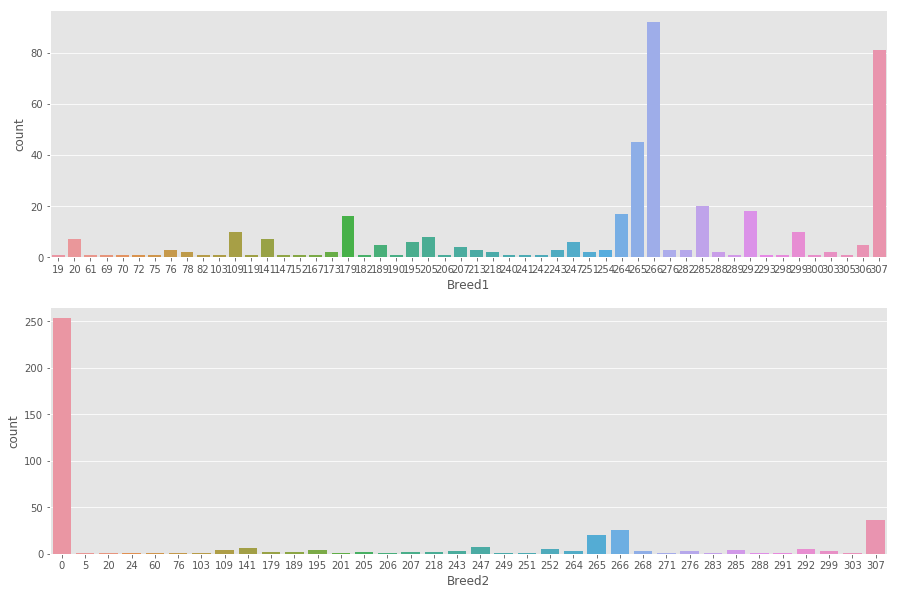

In [32]:
fig,axs = plt.subplots(figsize=(15,10), nrows=2,ncols=1)

sns.countplot(pets_as_zero['Breed1'],ax=axs[0]);
sns.countplot(pets_as_zero['Breed2'],ax=axs[1]);

In [33]:
breeds_dict = {k: v for k, v in zip(breeds['BreedID'], breeds['BreedName'])}

In [34]:
train['Breed1_name'] = train['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
train['Breed2_name'] = train['Breed2'].apply(lambda x: '_'.join(breeds_dict[x]) if x in breeds_dict else '-')

test['Breed1_name'] = test['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
test['Breed2_name'] = test['Breed2'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else '-')

all_data['Breed1_name'] = all_data['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
all_data['Breed2_name'] = all_data['Breed2'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else '-')

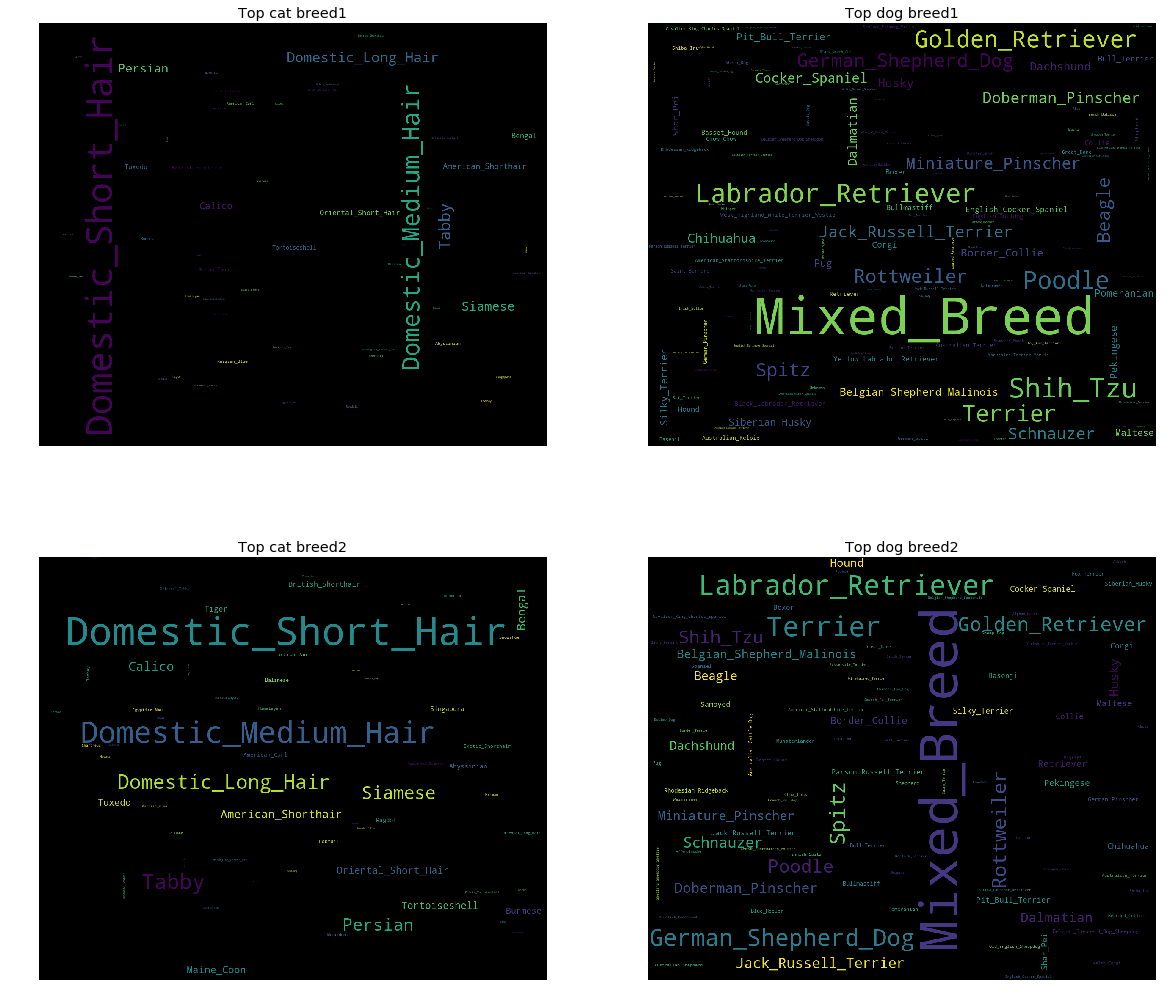

In [35]:
fig, ax = plt.subplots(figsize = (20, 18))
plt.subplot(2, 2, 1)
text_cat1 = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_cat1)
plt.imshow(wordcloud)
plt.title('Top cat breed1')
plt.axis("off")

plt.subplot(2, 2, 2)
text_dog1 = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Breed1_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_dog1)
plt.imshow(wordcloud)
plt.title('Top dog breed1')
plt.axis("off")

plt.subplot(2, 2, 3)
text_cat2 = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Breed2_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_cat2)
plt.imshow(wordcloud)
plt.title('Top cat breed2')
plt.axis("off")

plt.subplot(2, 2, 4)
text_dog2 = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Breed2_name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text_dog2)
plt.imshow(wordcloud)
plt.title('Top dog breed2')
plt.axis("off")
plt.show()

It seems that not all values of these features are really breeds. Sometimes rescuers simply write that the dogs has a mixed breed, cats often are described as domestic with certain hair length.

### Gender
 1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets

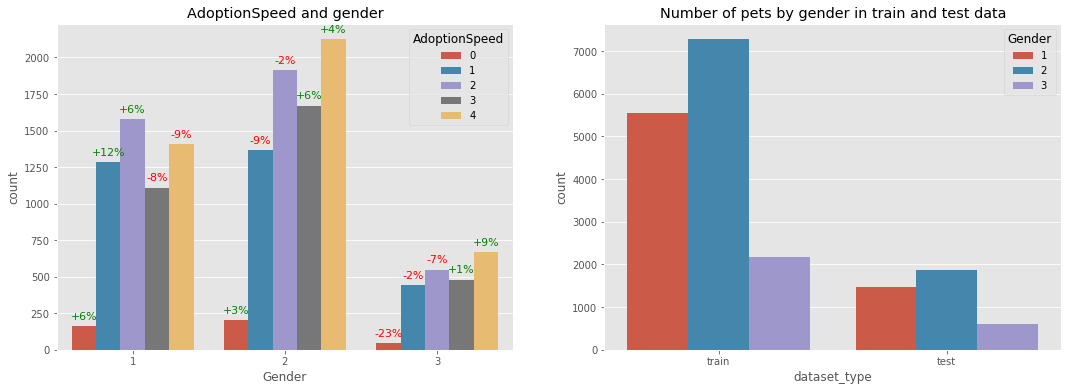

In [36]:
plt.figure(figsize=(18, 6));
plt.subplot(1, 2, 1)
make_count_plot(df=train, x='Gender', title='and gender')

plt.subplot(1, 2, 2)
sns.countplot(x='dataset_type', data=all_data, hue='Gender');
plt.title('Number of pets by gender in train and test data');

It seems that male pets are adopted faster than female. Having no information about the gender really decreases chances.

### Colors

In [37]:
colors_dict = {k: v for k, v in zip(colors['ColorID'], colors['ColorName'])}
train['Color1_name'] = train['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color2_name'] = train['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color3_name'] = train['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

test['Color1_name'] = test['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color2_name'] = test['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color3_name'] = test['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

all_data['Color1_name'] = all_data['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color2_name'] = all_data['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color3_name'] = all_data['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

In [38]:
def make_factor_plot(df, x, col, title, main_count=main_count, hue=None, ann=True, col_wrap=4):
    """
    Plotting countplot.
    """
    if hue:
        g = sns.factorplot(col, col=x, data=df, kind='count', col_wrap=col_wrap, hue=hue);
    else:
        g = sns.factorplot(col, col=x, data=df, kind='count', col_wrap=col_wrap);
    plt.subplots_adjust(top=0.9);
    plt.suptitle(title);
    ax = g.axes
    plot_dict = prepare_plot_dict(df, x, main_count)
    if ann:
        for a in ax:
            for p in a.patches:
                text = f"{plot_dict[p.get_height()]:.0f}%" if plot_dict[p.get_height()] < 0 else f"+{plot_dict[p.get_height()]:.0f}%"
                a.annotate(text, (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='green' if plot_dict[p.get_height()] > 0 else 'red', rotation=0, xytext=(0, 10),
                     textcoords='offset points')  

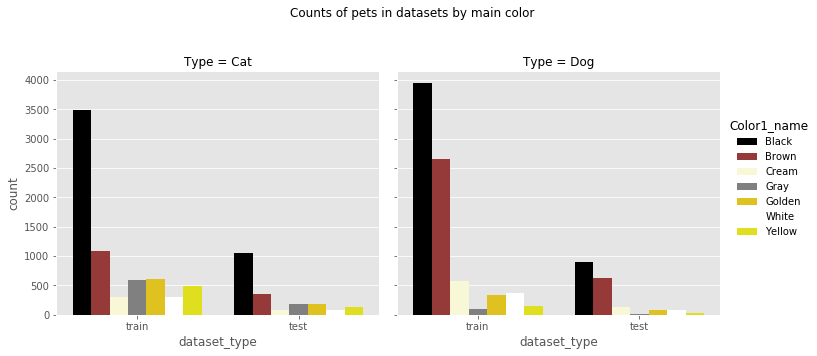

In [39]:
sns.factorplot('dataset_type', col='Type', data=all_data, kind='count', hue='Color1_name', palette=['Black', 'Brown', '#FFFDD0', 'Gray', 'Gold', 'White', 'Yellow']);
plt.subplots_adjust(top=0.8)
plt.suptitle('Counts of pets in datasets by main color');

We can see that most common colors are black and brown. Interesting to notice that there are almost no gray or yellow dogs.

### MaturitySize
Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)

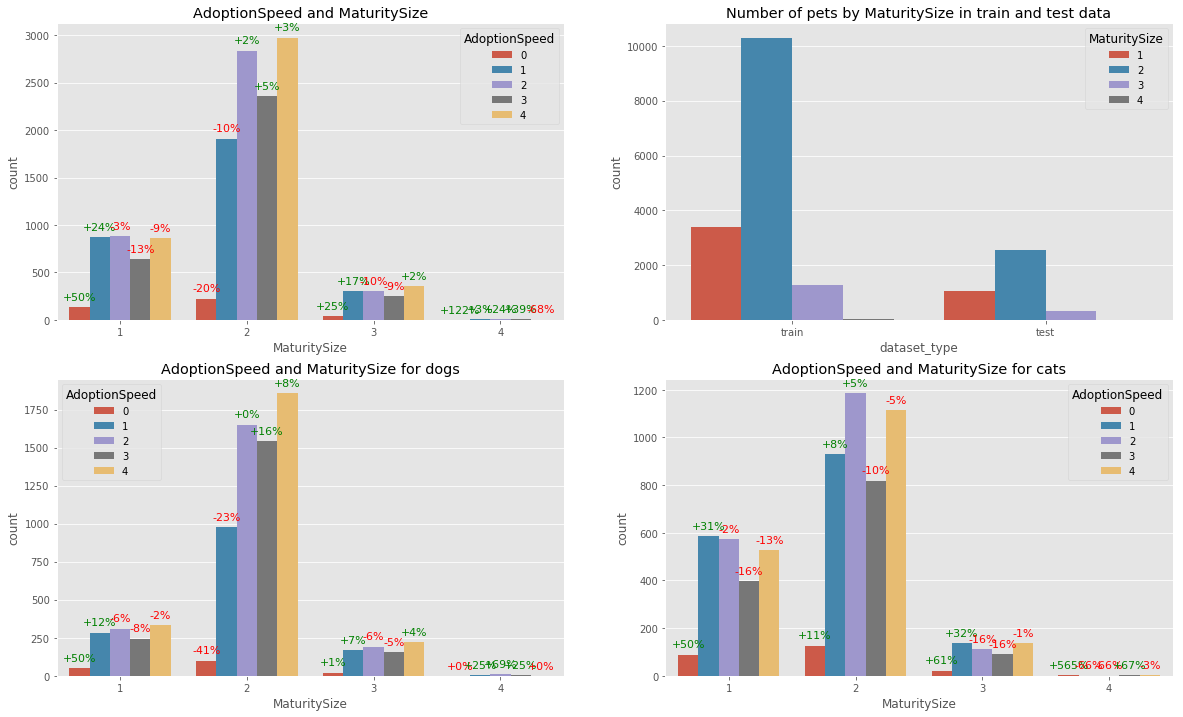

In [40]:
plot_four_graphs(col='MaturitySize', main_title='MaturitySize', dataset_title='Number of pets by MaturitySize in train and test data')

Observations:
* We can see that maturity size isn't very important. Medium sized pets are most common and they have slightly more chances to be not adopted
* There are almost no Extra Large pets

### FurLength

 (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

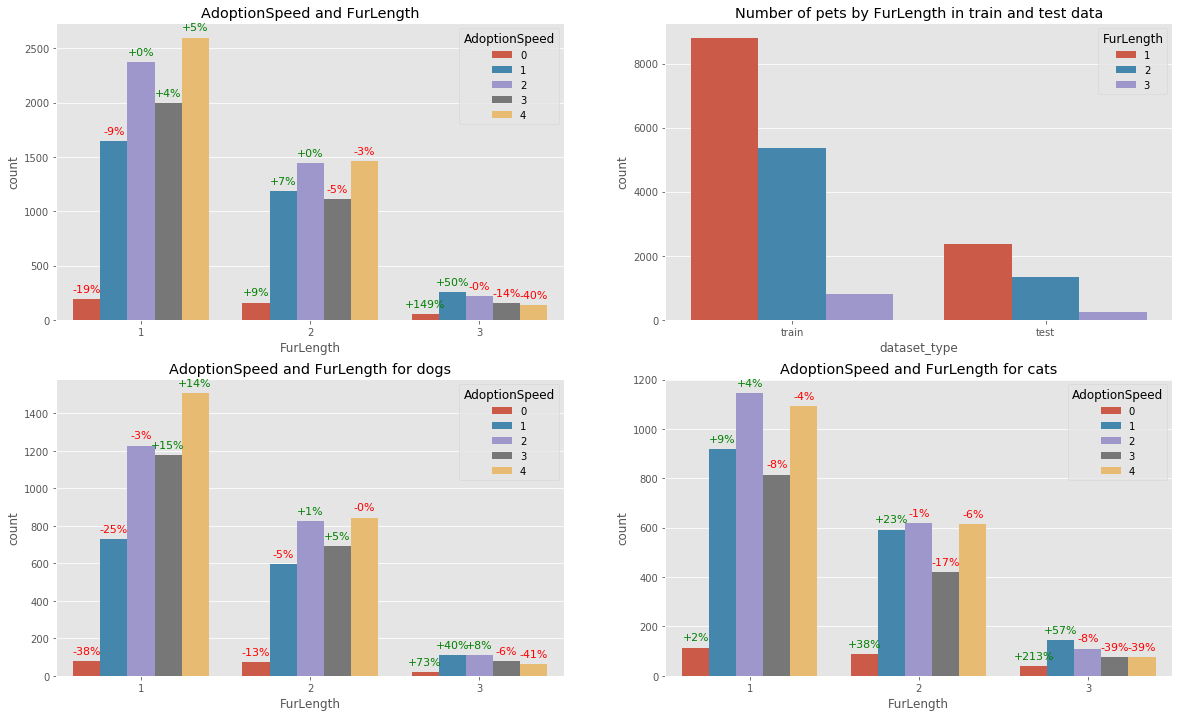

In [41]:
plot_four_graphs(col='FurLength', main_title='FurLength', dataset_title='Number of pets by FurLength in train and test data')

* We can see that most of the pets have short fur and long fur is the least common
* Pets with long hair tend to have a higher chance of being adopted. Though it could be because of randomness due to low count

### Health

There are four features showing health of the pets:

* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

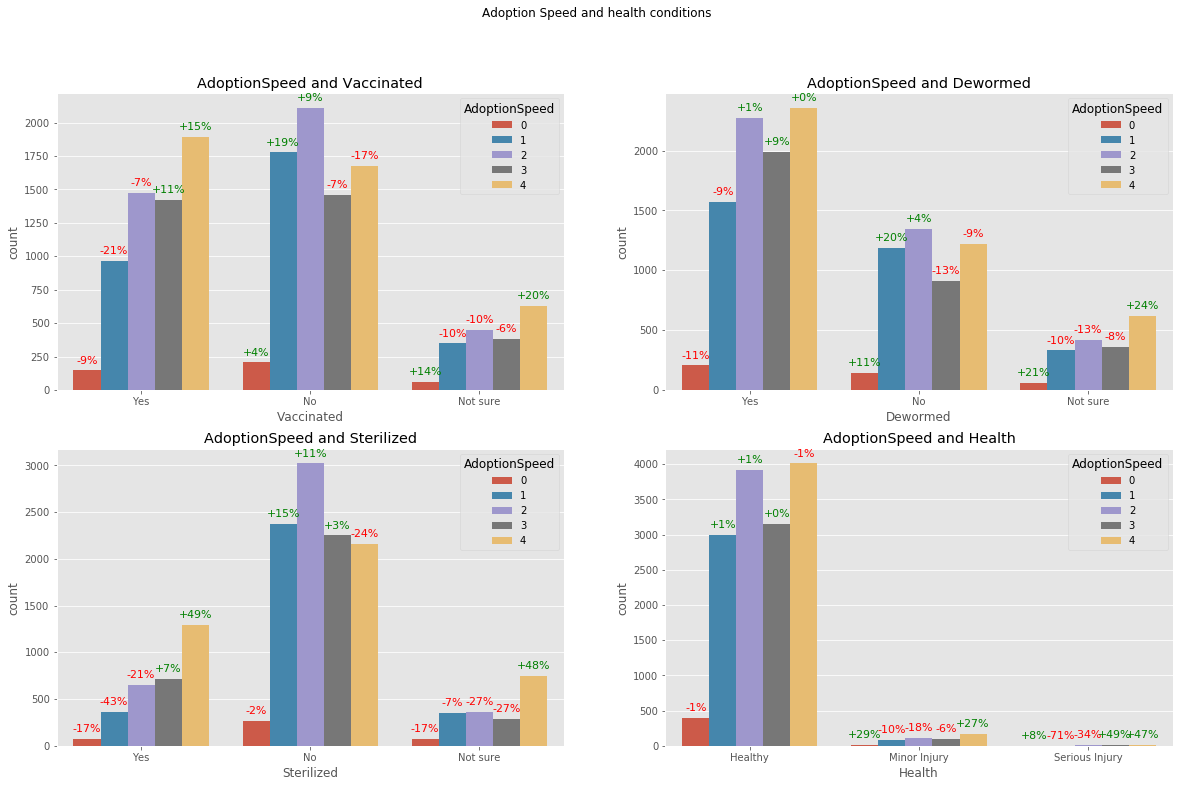

In [42]:
plt.figure(figsize=(20, 12));
plt.subplot(2, 2, 1)
make_count_plot(df=train, x='Vaccinated', title='Vaccinated')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Vaccinated');

plt.subplot(2, 2, 2)
make_count_plot(df=train, x='Dewormed', title='Dewormed')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Dewormed');

plt.subplot(2, 2, 3)
make_count_plot(df=train, x='Sterilized', title='Sterilized')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Sterilized');

plt.subplot(2, 2, 4)
make_count_plot(df=train, x='Health', title='Health')
plt.xticks([0, 1, 2], ['Healthy', 'Minor Injury', 'Serious Injury']);
plt.title('AdoptionSpeed and Health');

plt.suptitle('Adoption Speed and health conditions');

* Most pets are healthy. Pets with minor injuries are rare and sadly they aren't adopted well. Number of pets with serious injuries is negligible.
* People also prefer non-sterilized pets! Maybe they want puppies/kittens or younger one's

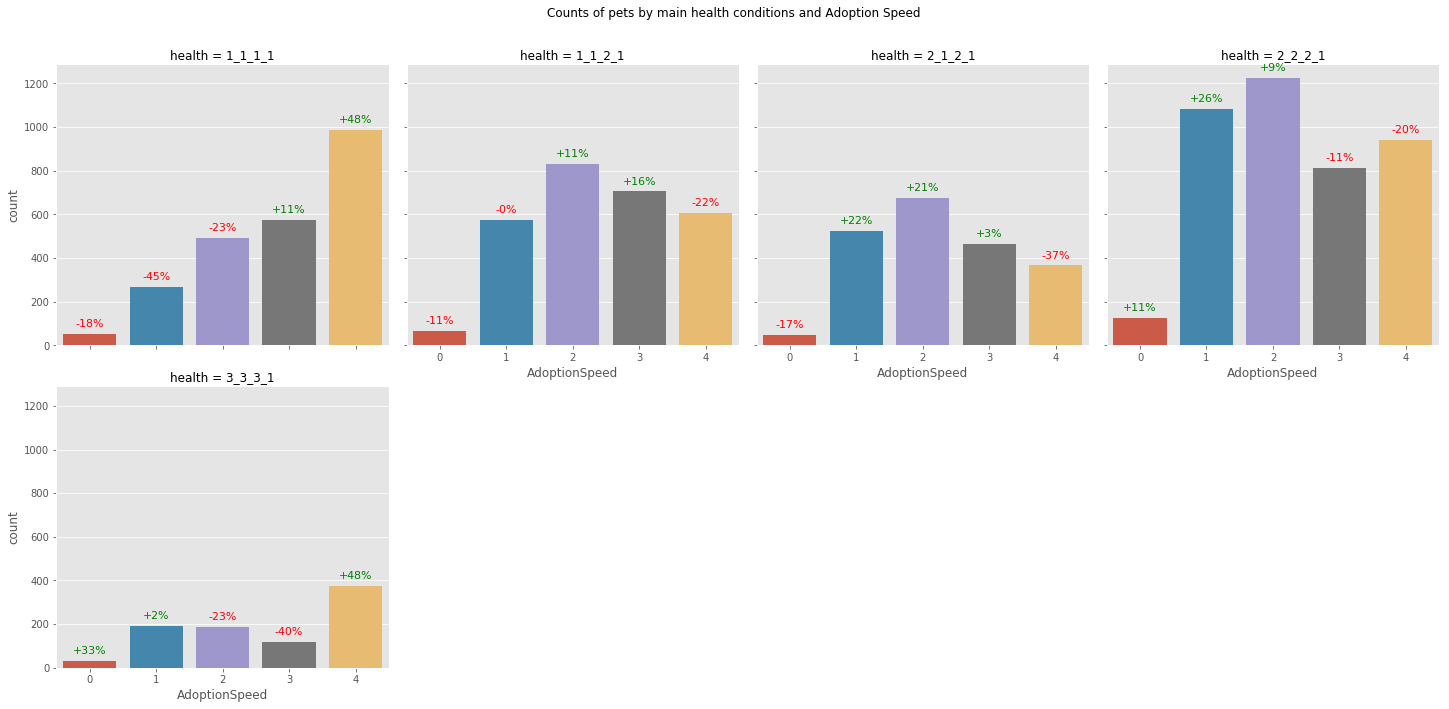

In [43]:
train['health'] = train['Vaccinated'].astype(str) + '_' + train['Dewormed'].astype(str) + '_' + train['Sterilized'].astype(str) + '_' + train['Health'].astype(str)
test['health'] = test['Vaccinated'].astype(str) + '_' + test['Dewormed'].astype(str) + '_' + test['Sterilized'].astype(str) + '_' + test['Health'].astype(str)


make_factor_plot(df=train.loc[train['health'].isin(list(train.health.value_counts().index[:5]))], x='health', col='AdoptionSpeed', title='Counts of pets by main health conditions and Adoption Speed')

* Healthy, dewormed and non-sterilized pets tend to be adopted faster
* And healthy pets with no information (not sure value) also tend to be adopted less frequently

### Quantity
Sometimes there are a number of pets in one listing

In [44]:
train.loc[train['Quantity'] > 11][['Name', 'Description', 'Quantity', 'AdoptionSpeed']].head(5)

,Name,Description,Quantity,AdoptionSpeed
263,20 Little Puppies,"These are 20 puppies, from 2 stray mums need good homes. They are 2 weeks old. If you can give them a good home without caging or chaining, please whatsapp or msg Ms Grace Bong tel no:",20,4
320,18 Cats For NEED HOMES!!,"YOU can CONTACT the couple at if you are interested. MORE pictures available here: THE HISTORY: They were basically abandoned by their previous owner who left them behind when he moved out. The couple that moved in was left to look after them and has slowly been finding homes for the cats over the last year. There were 28 to begin with and there are 18 left. The last 18 NEED HOMES URGENTLY as the couple is no longer able to care for them. Due to some personal issues, and a new baby then need...",18,4
396,"Giant, Cookie & Snoopy. ! Thanks!","puppies for adoption. Rescued by some good samaritans. No information on breeds, probably mongrels. All about a month old. They have been dewormed but not yet vaccinated. Cookie- female- Smaller than the rest but fiesty! Snoopy- male- Attention seeker. LOVES wagging his tail! Giant- male- Gentle giant. Very soft fur coat! Very playful! Some videos: Giant and his tennis ball- Giant playing with Snoopy- Giant being bullied- ----------------------------------------------------------------------...",12,2
427,OMIEY'S HOME,"Hi, kepada sesiapa yang berminat untuk adopt kucing-kucing sila hubungi saya . Di sini ada berbagai jenis kucing, dari short hair - long hair.",20,4
823,Pancho & Tita,"Pancho and Tita are 2 adorable, playful kittens. They can be shy at first but once they get to know you they are the sweetest pets anyone could ask for. Available for adoption now. They are very, very close so we are looking for someone who can take them both.",12,2


In [45]:
train['Quantity'].value_counts().head(5)

1    11565
2     1422
3      726
4      531
5      333
Name: Quantity, dtype: int64

Sometimes there is a huge amount of pets in some advertisements! But at the same time sometimes text and the quantity don't match. For example:

    Pancho and Tita are 2 adorable, playful kittens. They can be shy at first but once they get to know you they are the sweetest pets anyone could ask for. Available for adoption now. They are very, very close so we are looking for someone who can take them both.
    
 Obvously there are only two kittens, but the quantity is 12 for some reason. These are listing errors.

### Fee
One of interesting features is adoption fee. Some pets are listed for free, adopting some required paying a certain amount.

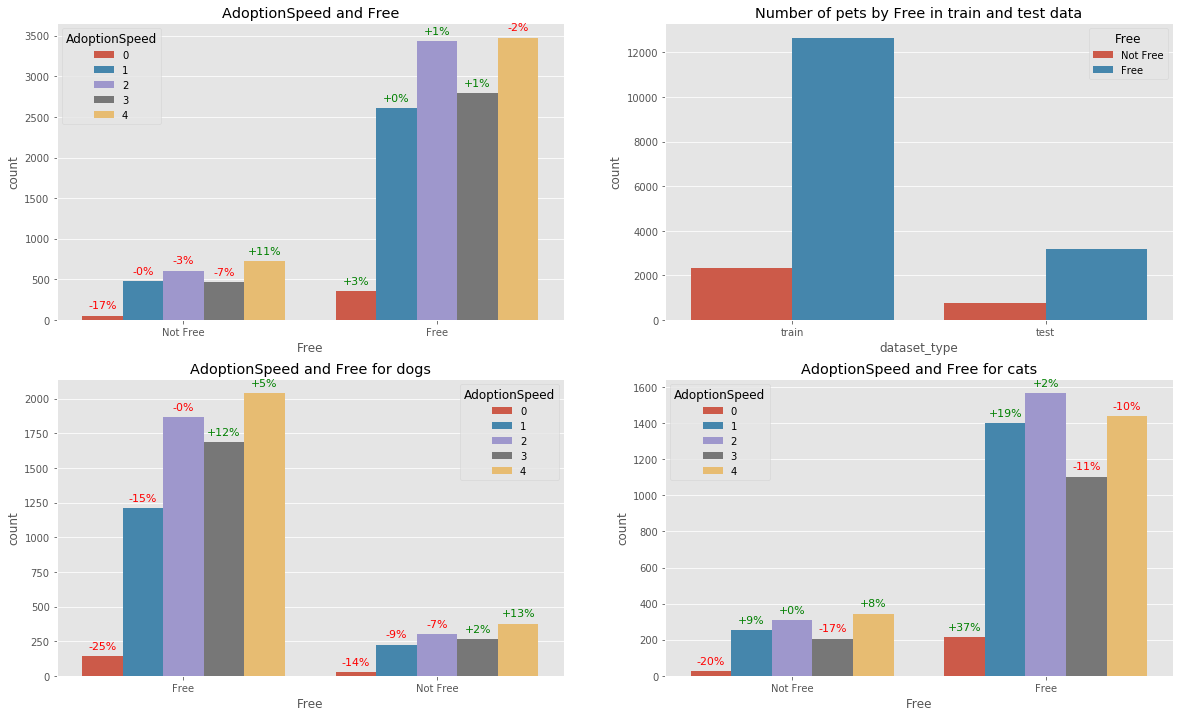

In [46]:
train['Free'] = train['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
test['Free'] = test['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
all_data['Free'] = all_data['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
plot_four_graphs(col='Free', main_title='Free', dataset_title='Number of pets by Free in train and test data')

Most pets are free and it seems that asking for a fee slightly desreased the chance of adoption. Also free cats are adopted faster than free dogs

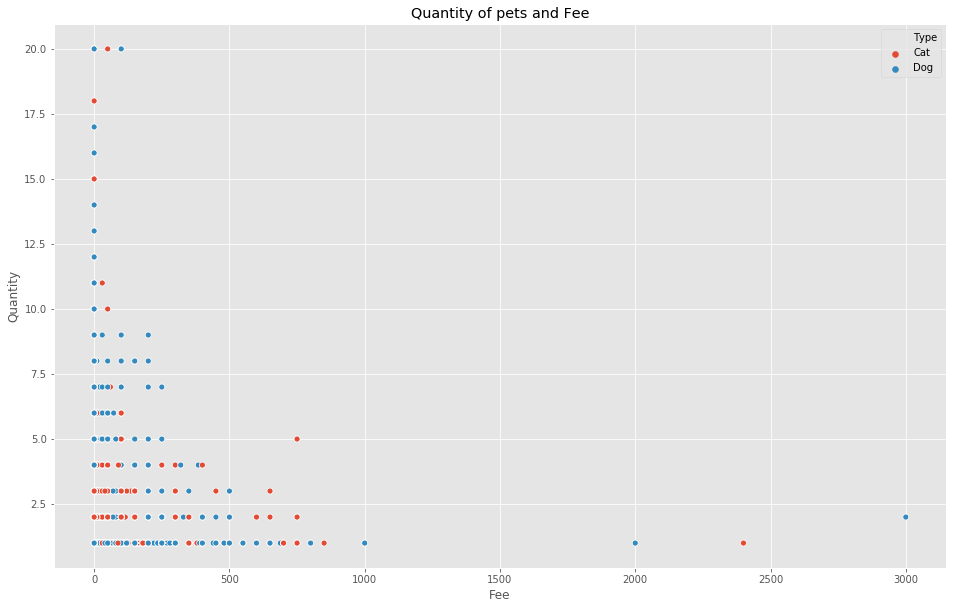

In [47]:
plt.figure(figsize=(16, 10));
sns.scatterplot(x="Fee", y="Quantity", hue="Type",data=all_data);
plt.title('Quantity of pets and Fee');

It seems that fees and pet quantity have inversely proportional relationship. The less pets, the higher is the fee.

### Rescuer
We have unique IDs for rescuers.

In [48]:
all_data['RescuerID'].value_counts().head()

fa90fa5b1ee11c86938398b60abc32cb    459
aa66486163b6cbc25ea62a34b11c9b91    315
c00756f2bdd8fa88fc9f07a8309f7d5d    231
b53c34474d9e24574bcec6a3d3306a0d    228
ee2747ce26468ec44c7194e7d1d9dad9    156
Name: RescuerID, dtype: int64

Top-5 rescuers handled a lot of pets. They maybe organizations.

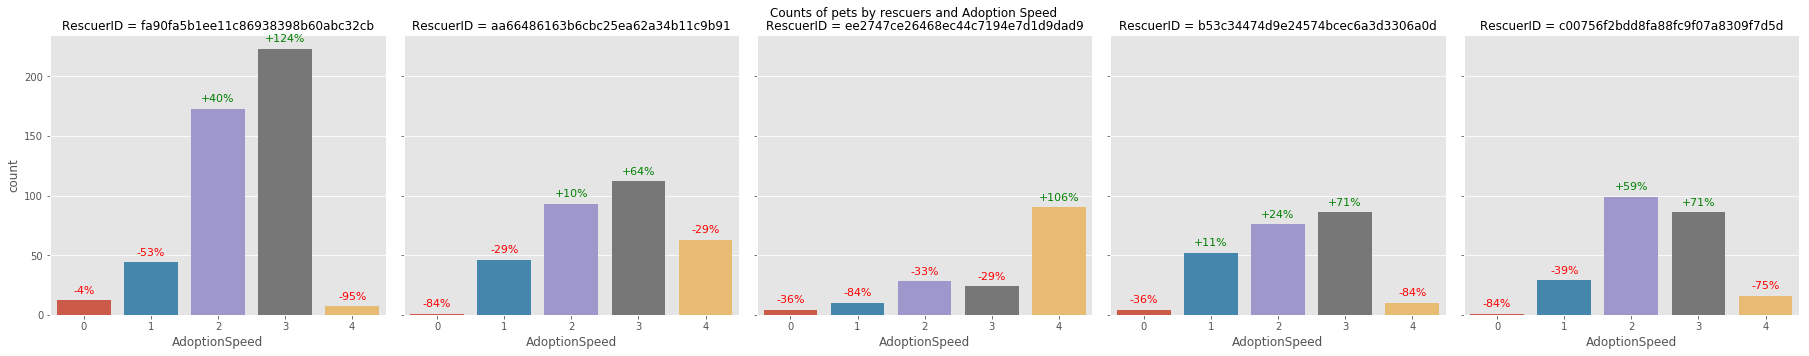

In [49]:
make_factor_plot(df=train.loc[train['RescuerID'].isin(list(train.RescuerID.value_counts().index[:5]))], x='RescuerID', col='AdoptionSpeed', title='Counts of pets by rescuers and Adoption Speed', col_wrap=5)

Interestingly, the rescuer with the highest amount of rescued pets has the best adoption rate.

### VideoAmt

In [50]:
train['VideoAmt'].value_counts()

0    14419
1      417
2       92
3       36
4       15
5        7
6        4
8        2
7        1
Name: VideoAmt, dtype: int64

In most cases there are no videos at all.

### PhotoAmt

In [51]:
print(F'Maximum amount of photos in {train["PhotoAmt"].max()}')
train['PhotoAmt'].value_counts().head()

Maximum amount of photos in 30.0


1.0    3075
2.0    2518
3.0    2511
5.0    2147
4.0    1881
Name: PhotoAmt, dtype: int64

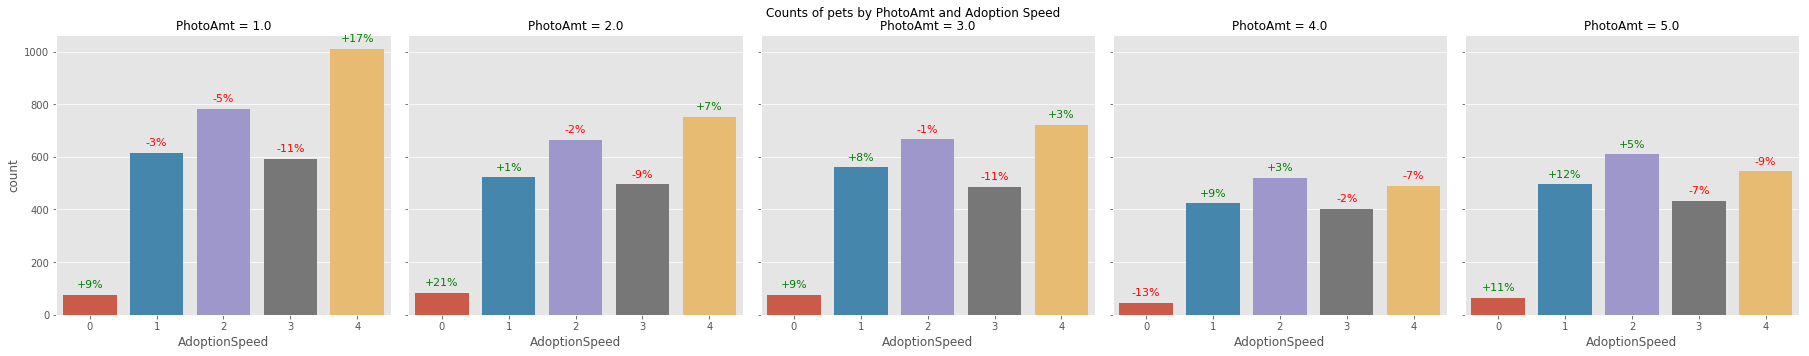

In [52]:
make_factor_plot(df=train.loc[train['PhotoAmt'].isin(list(train.PhotoAmt.value_counts().index[:5]))], x='PhotoAmt', col='AdoptionSpeed', title='Counts of pets by PhotoAmt and Adoption Speed', col_wrap=5)

### Description

Description contains a lot of important information about the listing.

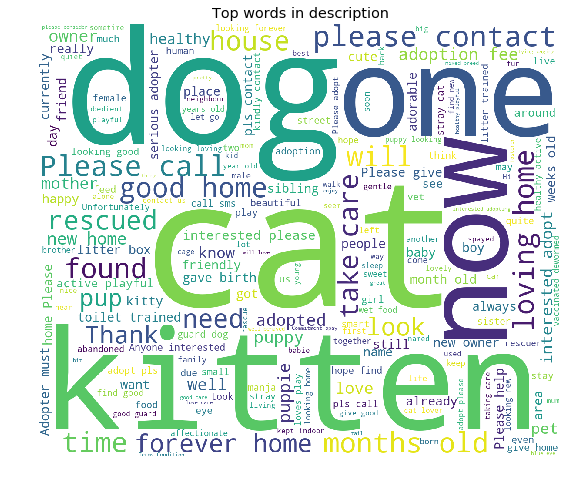

In [53]:
fig, ax = plt.subplots(figsize = (12, 8))
text_cat = ' '.join(all_data['Description'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top words in description');
plt.axis("off");

There are too many similar general words like "cat" and "dog". We can use ELI5 library for prediction explanation. We will fit a basic vectorizer on desctriptions and build a simple Random Forest model. Then we will look at words which caused certain labels to be predicted.

In [54]:
tokenizer = TweetTokenizer()
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)

vectorizer.fit(all_data['Description'].fillna('').values)
X_train = vectorizer.transform(train['Description'].fillna(''))

rf = RandomForestClassifier(n_estimators=20)
rf.fit(X_train, train['AdoptionSpeed'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
for i in range(5):
    print(f'Example of Adoption speed {i}')
    text = train.loc[train['AdoptionSpeed'] == i, 'Description'].values[0]
    print(text)
    display(eli5.show_prediction(rf, doc=text, vec=vectorizer, top=10))

Example of Adoption speed 0
I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.


Example of Adoption speed 1
anyone within the area of ipoh or taiping who interested to adopt my cat can contact my father at this number (mazuvil)or can just email me. currently bulat is at my hometown at perak but anyone outside the area still want to adopt can travel there to my hometown.there is a lot of cats in my house rite now..i think i should let one of them go to a better owner who can give better attention to him.


Example of Adoption speed 2
Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.


Example of Adoption speed 3
Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.


Example of Adoption speed 4
Very manja and gentle stray cat found, we would really like to find a home for it because we cannot keep her for ourselves for long. Has a very cute high pitch but soft meow. Please contact me if you would be interested in adopting.


Some words/phrases seem to be useful, but it seems that different adoption speed classes could have similar important words.

In [56]:
train['Description'] = train['Description'].fillna('')
test['Description'] = test['Description'].fillna('')
all_data['Description'] = all_data['Description'].fillna('')

train['desc_length'] = train['Description'].apply(lambda x: len(x))
train['desc_words'] = train['Description'].apply(lambda x: len(x.split()))

test['desc_length'] = test['Description'].apply(lambda x: len(x))
test['desc_words'] = test['Description'].apply(lambda x: len(x.split()))

all_data['desc_length'] = all_data['Description'].apply(lambda x: len(x))
all_data['desc_words'] = all_data['Description'].apply(lambda x: len(x.split()))

train['averate_word_length'] = train['desc_length'] / train['desc_words']
test['averate_word_length'] = test['desc_length'] / test['desc_words']
all_data['averate_word_length'] = all_data['desc_length'] / all_data['desc_words']

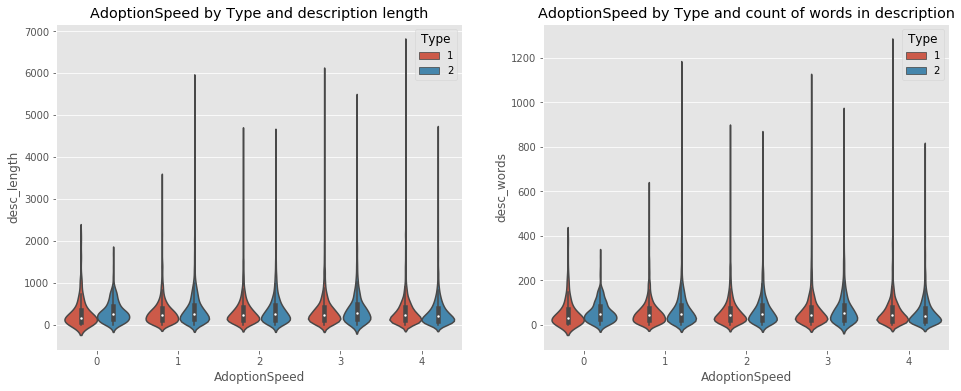

In [57]:
plt.figure(figsize=(16, 6));
plt.subplot(1, 2, 1)
sns.violinplot(x="AdoptionSpeed", y="desc_length", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and description length');

plt.subplot(1, 2, 2)
sns.violinplot(x="AdoptionSpeed", y="desc_words", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and count of words in description');

Pets with short text in listings are adopted quickly. Also, longer descriptions may mean more problems in the pets, therefore adoption speed could be lower.